In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis

In [2]:
movies = pd.read_csv('../src/data/raw/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [4]:
movies.shape

(27278, 3)

In [5]:
gscores = pd.read_csv('../src/data/raw/genome-scores.csv')
gscores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [6]:
gtags = pd.read_csv('../src/data/raw/genome-tags.csv')
gtags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [7]:
gtags.shape

(1128, 2)

In [8]:
links = pd.read_csv('../src/data/raw/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
ratings = pd.read_csv('../src/data/raw/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


In [15]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of movies: {n_movies}")
print(f"Number of users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 20000263
Number of movies: 26744
Number of users: 138493
Average number of ratings per user: 144.41
Average number of ratings per movie: 747.84


rating
4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: count, dtype: int64


<Axes: xlabel='rating', ylabel='Count'>

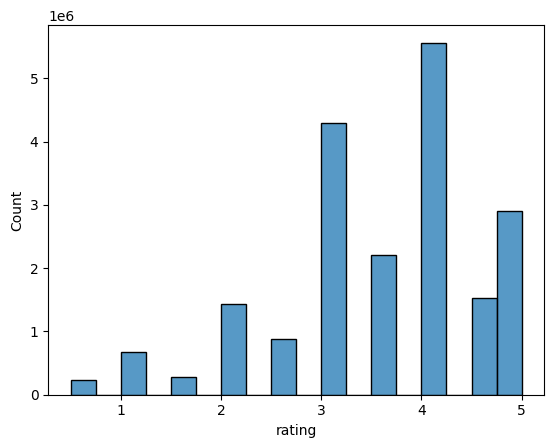

In [11]:
# Les ratings sont très largement skewed-right (bcp plus de ratings élevés - 4, 4.5, 5 - que de ratings faibles - 1, 1.5, 2)
print(ratings['rating'].value_counts())
sns.histplot(ratings, x='rating', binwidth=0.25)

In [12]:
# Les ratings vont de 0.5 à 5
print(ratings['rating'].min())
print(ratings['rating'].max())


0.5
5.0


In [13]:
# Les films présents dans la BDD vont de 1995 à 2015
print(datetime.fromtimestamp(ratings['timestamp'].min()))
print(datetime.fromtimestamp(ratings['timestamp'].max()))

1995-01-09 12:46:44
2015-03-31 08:40:02


# Retro Engineering Fonctionnement User Matrix - Modèle de Base

In [14]:
user_matrix = pd.read_csv('../src/data/processed/user_matrix.csv')
user_matrix.head()

,userId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0.0,0.129412,0.123529,0.029412,0.082353,0.352941,0.141176,0.029412,0.505882,...,0.017647,0.076471,0.005882,0.041176,0.047059,0.205882,0.076471,0.182353,0.041176,0.023529
1,2,0.0,0.083333,0.100000,0.033333,0.066667,0.383333,0.033333,0.033333,0.483333,...,0.016667,0.116667,0.000000,0.066667,0.050000,0.233333,0.083333,0.233333,0.050000,0.016667
2,3,0.0,0.127072,0.088398,0.022099,0.055249,0.298343,0.071823,0.027624,0.475138,...,0.027624,0.116022,0.000000,0.038674,0.044199,0.132597,0.116022,0.176796,0.049724,0.011050
3,4,0.0,0.178571,0.142857,0.071429,0.071429,0.357143,0.035714,0.035714,0.571429,...,0.000000,0.035714,0.035714,0.107143,0.071429,0.107143,0.000000,0.178571,0.035714,0.107143
4,5,0.0,0.142857,0.095238,0.079365,0.126984,0.380952,0.015873,0.063492,0.555556,...,0.000000,0.047619,0.015873,0.079365,0.063492,0.142857,0.031746,0.238095,0.031746,0.015873


In [15]:
# Split the 'genres' column into individual genres
genres = movies["genres"].str.get_dummies(sep="|")

# Concatenate the original movieId and title columns with the binary genre columns
movies_genres = pd.concat([movies[["movieId", "title"]], genres], axis=1)
movies_genres.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
movie_ratings = ratings.merge(movies_genres, on="movieId", how="inner")
movie_ratings.head()

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,1112486027,Jumanji (1995),0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,29,3.5,1112484676,"City of Lost Children, The (CitÃ© des enfants ...",0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [17]:
# Drop useless features
movie_ratings = movie_ratings.drop(columns = ["movieId", "timestamp", "title", "rating"])
movie_ratings.head()

,userId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [18]:
# Calculate user_matrix
user_matrix = movie_ratings.groupby("userId").agg(
    "mean",
)

user_matrix.head()

# Tentative Collaborative Filtering

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


## Méthode 1 - Numpy Matrix

In [ ]:
# Réduction mémoire dataframe
ratings['userId'] = ratings['userId'].astype(np.int32)
ratings['movieId'] = ratings['movieId'].astype(np.int32)
ratings['rating'] = ratings['rating'].astype(np.float16)

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float16
 3   timestamp  int64  
dtypes: float16(1), int32(2), int64(1)
memory usage: 343.3 MB


In [ ]:
# Filtrage des films sur la base du nombre de ratings > 10000

nb_ratings_per_movie = ratings.groupby('movieId')['rating'].count().reset_index().sort_values(by = 'rating', ascending = False)

print(nb_ratings_per_movie[nb_ratings_per_movie['rating'] > 10000].shape)
print(nb_ratings_per_movie.head())

(462, 2)
     movieId  rating
293      296   67310
352      356   66172
315      318   63366
587      593   63299
476      480   59715


In [ ]:
movies_sup_10000_ratings = nb_ratings_per_movie[nb_ratings_per_movie['rating'] > 10000]['movieId'].to_list()
ratings_popular_movies = ratings[ratings['movieId'].isin(movies_sup_10000_ratings)].reset_index().drop(columns = 'index')
ratings_popular_movies.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,32,3.5,1112484819
2,1,47,3.5,1112484727
3,1,50,3.5,1112484580
4,1,112,3.5,1094785740


In [ ]:
ratings_popular_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9050396 entries, 0 to 9050395
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float16
 3   timestamp  int64  
dtypes: float16(1), int32(2), int64(1)
memory usage: 155.4 MB


In [ ]:
ratings_popular_movies.shape

(9050396, 4)

In [ ]:
# Create unique indices for user and movie IDs
user_ids = np.unique(ratings_popular_movies['userId'])
movie_ids = np.unique(ratings_popular_movies['movieId'])

# Create mappings from user/movie IDs to indices
user_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Number of users and movies
num_users = len(user_ids)
num_movies = len(movie_ids)

In [ ]:
print(num_movies)

462


In [ ]:
# Initialize the user-item matrix with zeros
user_item_matrix = np.zeros((num_users, num_movies))

# Populate the matrix
for _, row in ratings_popular_movies.iterrows():
    user_idx = user_index[row['userId']]
    movie_idx = movie_index[row['movieId']]
    user_item_matrix[user_idx, movie_idx] = row['rating']

In [ ]:
# Display part of the matrix
print(user_item_matrix[:10, :10])  # Print a small part to check


[[0.  3.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  4.  0.  0.  0.  0.  0.  0.  0. ]
 [4.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  3.  0.  4.  0.  0.  0. ]
 [0.  3.  0.  0.  0.  0.  0.  5.  0.  3. ]
 [5.  0.  3.  0.  0.  5.  0.  0.  0.  5. ]
 [0.  0.  3.  0.  0.  3.  0.  4.  3.  2. ]
 [4.  0.  5.  0.  3.  0.  4.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [4.  0.  0.  0.  0.  0.  0.  4.  0.  0. ]]


In [ ]:
# Save the matrix
np.save('../src/data/processed/user_item_matrix.npy', user_item_matrix)

In [ ]:
# Load the matrix
user_item_matrix = np.load('../src/data/processed/user_item_matrix.npy')
print(user_item_matrix.shape)

(137658, 462)


In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def train_model_knn(user_item_matrix, n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="ball_tree").fit(user_item_matrix)
    return nbrs

In [ ]:
def predict_ratings(model, n_neighbors):
    """
    Function predicts ratings for each of the top movie for the x first users based on n_neighbors defined in model training above.
    """
    predict_matrix = []

    for u in range(100):
        _, indices = model.kneighbors(user_item_matrix[u].reshape(1, -1))

        # Predicting rating for movies
        selected_rows = user_item_matrix[indices].reshape(n_neighbors, 462)
        similar_users_ratings = pd.DataFrame(selected_rows)
        similar_users_ratings = similar_users_ratings.replace(0, np.nan)

        # Calculate the mean of each column (ignoring NaNs)
        average_ratings = similar_users_ratings.mean()
        predict_matrix.append(np.array(average_ratings))

    return predict_matrix

In [ ]:
n_neighbors=10

model = train_model_knn(user_item_matrix, n_neighbors=n_neighbors)
predict_matrix = predict_ratings(model, n_neighbors=n_neighbors)


### ==> Résultats : 

- Préparation de la matrice trop longue (10 min, sans doute largement optimisable)
- Prédiction des notes sur l'ensemble des users demande trop de mémoire (dans l'exemple ci-dessus, j'ai dû limiter à 100 users dans la fonction => résultat entraînement et prédiction 100 users = 33 secondes)

In [ ]:
# Exemple de prédictions sur le user 0
predict_matrix[0]

array([3.5       , 3.        , 2.        ,        nan,        nan,
       0.5       ,        nan,        nan, 3.        ,        nan,
       3.        ,        nan,        nan, 3.1       ,        nan,
              nan,        nan,        nan, 3.3       ,        nan,
       3.57142857, 2.        ,        nan, 2.25      ,        nan,
       2.5       , 3.        , 3.5       , 2.125     ,        nan,
              nan, 3.5       , 3.        ,        nan,        nan,
              nan,        nan, 2.5       , 1.5       ,        nan,
       2.5       , 1.5       ,        nan,        nan,        nan,
              nan, 3.5       ,        nan,        nan, 3.        ,
              nan,        nan,        nan, 2.66666667, 3.35714286,
              nan,        nan,        nan,        nan,        nan,
              nan, 3.25      , 3.7       ,        nan,        nan,
              nan,        nan, 3.9       , 3.        ,        nan,
       3.5       ,        nan, 2.5       ,        nan,        

In [ ]:
# L'idée était ensuite de comparer la user_item_matrix des ratings constatés avec la predicted_matrix pour calculer une MAE
user_item_matrix_for_mae = pd.DataFrame(user_item_matrix).replace(0, np.nan)
user_item_matrix_for_mae

,0,1,2,3,4,5,6,7,8,9,...,452,453,454,455,456,457,458,459,460,461
0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
137654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137655,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
137656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### => Abandon de ce modèle

# Méthode 2 - SVD (Singular Value Decomposition) sur CSR Matrix 

In [78]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix

In [79]:
# Example data loading
ratings = pd.read_csv('../src/data/raw/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [80]:
# Réduction mémoire dataframe
ratings['rating'] = ratings['rating'].astype(np.float32)

In [81]:
def reduce_user_item_matrix(ratings, min_ratings_movie, min_ratings_user):
    """ Returns a dataframe containing userId, movieId, rating, timestamp filtered on number of ratings minimum defined as parameters"""

    # Count nb_ratings per movie and keep only movies with nb_ratings > min_ratings_movie
    nb_ratings_per_movie = ratings.groupby('movieId')['rating'].count().reset_index().sort_values(by = 'rating', ascending = False)
    movies_filtered = nb_ratings_per_movie[nb_ratings_per_movie['rating'] >= min_ratings_movie]['movieId'].to_list()
    ratings_movies_filtered = ratings[ratings['movieId'].isin(movies_filtered)].reset_index().drop(columns = 'index')

    # Count nb_ratings per movie and keep only movies with nb_ratings > min_ratings_user
    nb_ratings_per_user = ratings.groupby('userId')['rating'].count().reset_index()
    users_filtered = nb_ratings_per_user[nb_ratings_per_user['rating'] >= min_ratings_user]['userId'].to_list()
    ratings_users_filtered = ratings_movies_filtered[ratings_movies_filtered['userId'].isin(users_filtered)].reset_index().drop(columns = 'index')

    return ratings_users_filtered

In [82]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [83]:
ratings_filtered = reduce_user_item_matrix(ratings, min_ratings_movie=1000, min_ratings_user=0)

In [84]:
ratings_filtered.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [85]:
ratings_filtered.shape

(17765516, 4)

In [86]:
ratings_filtered['userId'].max()

138493

In [87]:
ratings_filtered['userId'].unique()

array([     1,      2,      3, ..., 138491, 138492, 138493], dtype=int64)

In [88]:
# Create a mapping for userId and movieId (if we don't do that, since the matrix has userId 138493, the sparse matrix contains 138493 rows)
user_id_mapping = {id: i for i, id in enumerate(ratings_filtered['userId'].unique())}
filteredusers_to_user_id = {i: id for i, id in enumerate(ratings_filtered['userId'].unique())}

movie_id_mapping = {id: i for i, id in enumerate(ratings_filtered['movieId'].unique())}
filteredmovie_to_movie_id = {i: id for i, id in enumerate(ratings_filtered['movieId'].unique())}

# Use the mapping to translate the original ids to the new form
ratings_filtered['userId'] = ratings_filtered['userId'].map(user_id_mapping)
ratings_filtered['movieId'] = ratings_filtered['movieId'].map(movie_id_mapping)

In [89]:
movie_id_mapping

{2: 0,
 29: 1,
 32: 2,
 47: 3,
 50: 4,
 112: 5,
 151: 6,
 223: 7,
 253: 8,
 260: 9,
 293: 10,
 296: 11,
 318: 12,
 337: 13,
 367: 14,
 541: 15,
 589: 16,
 593: 17,
 653: 18,
 919: 19,
 924: 20,
 1009: 21,
 1036: 22,
 1079: 23,
 1080: 24,
 1089: 25,
 1090: 26,
 1097: 27,
 1136: 28,
 1193: 29,
 1196: 30,
 1198: 31,
 1200: 32,
 1201: 33,
 1208: 34,
 1214: 35,
 1215: 36,
 1217: 37,
 1219: 38,
 1222: 39,
 1240: 40,
 1243: 41,
 1246: 42,
 1249: 43,
 1258: 44,
 1259: 45,
 1261: 46,
 1262: 47,
 1266: 48,
 1278: 49,
 1291: 50,
 1304: 51,
 1321: 52,
 1333: 53,
 1348: 54,
 1350: 55,
 1358: 56,
 1370: 57,
 1374: 58,
 1387: 59,
 1584: 60,
 1848: 61,
 1920: 62,
 1967: 63,
 1994: 64,
 1997: 65,
 2021: 66,
 2100: 67,
 2118: 68,
 2138: 69,
 2140: 70,
 2143: 71,
 2174: 72,
 2193: 73,
 2194: 74,
 2253: 75,
 2288: 76,
 2291: 77,
 2542: 78,
 2628: 79,
 2644: 80,
 2648: 81,
 2664: 82,
 2683: 83,
 2692: 84,
 2716: 85,
 2761: 86,
 2762: 87,
 2804: 88,
 2872: 89,
 2918: 90,
 2944: 91,
 2947: 92,
 2959: 93,
 29

In [110]:
ratings_matrix = csr_matrix((ratings_filtered.rating, (ratings_filtered.userId, ratings_filtered.movieId)), dtype=np.float32)
dense_ratings = ratings_matrix.toarray()

In [111]:
ratings_matrix.shape

(138493, 3159)

In [112]:
# SVD model
svd = TruncatedSVD(n_components=50, algorithm='randomized')
user_factors = svd.fit_transform(ratings_matrix)

In [113]:
# Making predictions
predicted_ratings_matrix = svd.inverse_transform(user_factors)

In [114]:
"""from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(dense_ratings))
print(scaler.mean_)
print(scaler.transform(dense_ratings))"""

'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nprint(scaler.fit(dense_ratings))\nprint(scaler.mean_)\nprint(scaler.transform(dense_ratings))'

In [115]:
def get_top10(userId):
    top10 = ratings[ratings['userId'] == userId]

    # Sort by rating in descending order
    sorted_df = top10.sort_values(by='rating', ascending=False)

    # Select top 10 movies
    top_movies = sorted_df.head(10)
    top_movies = top_movies.merge(movies, on = "movieId", how = "left")

    return top_movies[['title', 'genres']]

In [116]:
user_id_mapping[1003]

1002

In [117]:
def get_recommendations(userId):
    """ Gives movie recommendations based on predicted ratings using SVD
    
    Args: 
    userId: id of the user as described in user DB
    """
    svd_user_id = user_id_mapping[userId]
    user_ratings = dense_ratings[svd_user_id, :]
    predicted_ratings = predicted_ratings_matrix[svd_user_id, :]
    
    unrated_indices = np.where(user_ratings == 0)[0]
    unrated_predictions = predicted_ratings[unrated_indices]

    # 'argsort' returns the indices to sort the array, and we take the last 10 indices for the top values
    top_indices = np.argsort(unrated_predictions)[-10:][::-1]

    # Step 4: Retrieve the original indices of these top predictions
    top_original_indices = unrated_indices[top_indices]

    # The top 10 predicted ratings
    top_ratings = unrated_predictions[top_indices]

    print("Top 10 predicted ratings:", top_ratings)
    print("Filtered Indices of top 10 predicted ratings:", top_original_indices)

    movies_list = [filteredmovie_to_movie_id[i] for i in top_original_indices]
    print("Original Indices of top 10 predicted ratings:", movies_list)
    print("\n")

    for i in movies_list:
        print(movies[movies['movieId'] == i]['title'].values[0] + " | " + movies[movies['movieId'] == i]['genres'].values[0])



In [118]:
get_top10(1000)

,title,genres
0,Watchmen (2009),Action|Drama|Mystery|Sci-Fi|Thriller|IMAX
1,Batman Begins (2005),Action|Crime|IMAX
2,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
3,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
4,Fight Club (1999),Action|Crime|Drama|Thriller
5,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
7,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
8,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
9,Alien: Resurrection (1997),Action|Horror|Sci-Fi


In [119]:
get_recommendations(1000)

Top 10 predicted ratings: [1.744913  1.7185593 1.5880252 1.4855547 1.4640068 1.4291888 1.4089059
 1.407172  1.4022716 1.2865018]
Filtered Indices of top 10 predicted ratings: [1655  289 2403  729 1647 1383  844  748  851  139]
Original Indices of top 10 predicted ratings: [54286, 2329, 68157, 4973, 49272, 5418, 48394, 5618, 51662, 6539]


Bourne Ultimatum, The (2007) | Action|Crime|Thriller
American History X (1998) | Crime|Drama
Inglourious Basterds (2009) | Action|Drama|War
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001) | Comedy|Romance
Casino Royale (2006) | Action|Adventure|Thriller
Bourne Identity, The (2002) | Action|Mystery|Thriller
Pan's Labyrinth (Laberinto del fauno, El) (2006) | Drama|Fantasy|Thriller
Spirited Away (Sen to Chihiro no kamikakushi) (2001) | Adventure|Animation|Fantasy
300 (2007) | Action|Fantasy|War|IMAX
Pirates of the Caribbean: The Curse of the Black Pearl (2003) | Action|Adventure|Comedy|Fantasy


In [120]:
# Calculate MAE
test_dense = dense_ratings
test_predicted = predicted_ratings_matrix

# Filter out the entries where given_ratings are zero
mask = dense_ratings != 0
filtered_given_ratings = dense_ratings[mask]
filtered_predicted_ratings = predicted_ratings_matrix[mask]


mae = mean_absolute_error(dense_ratings, predicted_ratings_matrix)
print(f'Mean Absolute Error: {mae}')

mae = np.mean(np.abs(filtered_given_ratings - filtered_predicted_ratings))
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 0.21015635132789612
Mean Absolute Error: 1.9935499429702759


# Export fixtures pour tests

In [ ]:
user_matrix = pd.read_csv('../src/data/processed/user_matrix.csv')

user_matrix_1000 = user_matrix[:1000]
user_matrix_1000.to_csv('../tests/fixtures/user_matrix_test.csv', index = None)

In [ ]:
movie_matrix = pd.read_csv('../src/data/processed/movie_matrix.csv')

movie_matrix_1000 = movie_matrix[:1000]
movie_matrix_1000.to_csv('../tests/fixtures/movie_matrix_test.csv', index = None)


In [ ]:
from src.features.build_features import read_movies, create_user_matrix


In [ ]:
movies = pd.DataFrame({
        'movieId': [1, 2, 3, 4, 5],
        'title': ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)'],
        'Action': [0, 0, 0, 0, 0],
        'Adventure': [1, 1, 0, 0, 0]
    })

ratings = pd.DataFrame({
    'userId': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
    'movieId': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'rating': [1.0, 2.0, 3.0, 4.0, 5.0, 5.0, 4.0, 3.0, 2.0, 1.0],
    'timestamp': [1112486027, 1112486028, 1112486029, 1112486030, 1112486031, 1112486032, 1112486033, 1112486034, 1112486035, 1112486036]
})

user_matrix = create_user_matrix(ratings, movies)

expected = pd.DataFrame({
    'userId': [0, 1],
    'Action': [0.0, 0.0],
    'Adventure': [0.4, 0.4]
})

expected = expected.set_index('userId')
expected

,Action,Adventure
userId,,
0,0.0,0.4
1,0.0,0.4


In [ ]:
expected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Action     2 non-null      float64
 1   Adventure  2 non-null      float64
dtypes: float64(2)
memory usage: 48.0 bytes


In [ ]:
user_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Action     2 non-null      float64
 1   Adventure  2 non-null      float64
dtypes: float64(2)
memory usage: 48.0 bytes
